In [443]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
import collections
import string
from collections import OrderedDict
import random
#from collections import Counter
num_regex = re.compile(r'\d+')

t_4200 = 4200.0
sigma99 = '0.56003'
sigma95 = '1.00180'
sigma90 = '1.51378'
pc_sigma_pair_99 = (99, sigma99)
pc_sigma_pair_95 = (95, sigma95)
pc_sigma_pair_90 = (90, sigma90)

In [363]:
def getDictOfRunCounters(sigma, percent, date=''):
    '''returns a dict of dicts with the run ID being the key and the items being a dict of the counters'''
    
    filename = 'counters_data/all_run_populations'+date+'_'+str(percent)+'/pyrithione-t=4200.0-parallel-event_counters_sigma='+str(sigma)+'.txt'
    runID_dict = {}
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=',')
        
        first_line = next(reader)
        idKey_prefix = first_line[0].replace('#', '').strip()
        counter_keys = [ck.strip() for ck in first_line[1:]]
        
        for line in reader:
            
            counter_dict = {}
            for ck, c_val in zip(counter_keys, line[1:]):
                counter_dict[ck] = c_val.strip()
            
            runID_key = idKey_prefix+' = '+line[0]
            runID_dict[runID_key] = counter_dict
            
    return runID_dict


In [371]:
def getDictOfPopDistbsAtEachTime(sigma, duration, percent, runID):
    #this returns a dict containing dicts of each microhab's populations at each timestep
    
    filename = 'counters_data/all_run_populations_'+str(percent)+'/pyrithione-t='+str(duration)+'-sigma='+str(sigma)+'-mh_pops-runID='+str(runID)+'.txt'
    timestep_dict = {}
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=",")

        for row in reader:
            
            if row[0].startswith('#'):
                t_val = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", row[0][:])[0]
                t_val = (float((t_val)))
                timekey = 't = '+'{:.1f}'.format(t_val)
                timestep_dict[timekey] = {}
                mh_index = 0
                
            else:
                if all(float(x) > 0 for x in row): mh_pop = [float(col.strip()) for col in row]
                else: mh_pop = []
                mh_key = 'mh = '+str(mh_index)
                timestep_dict[timekey][mh_key] = mh_pop
                mh_index += 1
          
                
    return timestep_dict


In [385]:
def plotGenosInMicroHabOverTime(geno_dict, mh_index, counter_dict, runID, percent):
    #geno_dict is the big dict that has the pop distbs with the times as keys
    #time_key = 't = 0'
    rando = lambda: random.randint(0,255)
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    percent_res = 100 - percent
    
    mh_key = 'mh = '+str(mh_index)
    color_dict = {}
    
    #this gets most resistant genotype in the geno_dict, used to compare for colour intensity
    max_geno_val = 0
    for t in geno_dict:
        for mh in geno_dict[t]:
            if len(geno_dict[t][mh]): 
                if max(geno_dict[t][mh]) > max_geno_val: max_geno_val = max(geno_dict[t][mh])
    
    
    #this sorted thing gets a list of the time keys sorted numerically
    #the regex removes all letters
    for time_key in sorted(geno_dict, key = lambda x: float(re.sub("\D", "", x)))[::]:
    
        geno_counts = dict(Counter(geno_dict[time_key][mh_key])) #gets the counts for each genotype
        geno_counts = dict(sorted(geno_counts.items())) #sorts them so least resistant at bottom
        
        bar_ypos = 0
        #geno_key is the numeric value of that genotype
        for geno_key, geno_count in sorted(geno_counts.items()):
            #this gives the number of each genotype present, from least resistant to most
            
            #allows for an arbitrary number of distinct colours to be used to label the genotypes
            #cast to int to group similar genos together, to take up less space on legend
            grouped_geno_key = int(geno_key)
            if grouped_geno_key in color_dict:
                geno_colour = color_dict[grouped_geno_key]
            else:
                geno_colour = '#%02X%02X%02X' % (rando(),rando(),rando())
                color_dict[grouped_geno_key] = geno_colour
                
            
            percent_of_max_r = grouped_geno_key/max_geno_val
            geno_colour2 = (percent_of_max_r, 0.3*percent_of_max_r, 0.42)
            
            #t = int(re.sub("\D", "", time_key))
            t = float(re.findall("\d+\.\d+", time_key)[0])
            #print(time_key)
            #print(t)
            ax.bar(x=t, height=geno_count, bottom=bar_ypos, color=geno_colour2, width=42, label=(grouped_geno_key))
            bar_ypos += geno_count
            
        
    #plt.xticks(x_indices, x_labels, fontsize=20, rotation = 45)
    ax.set_ylabel('n bacteria', fontsize=labelSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.tick_params(axis="x", labelsize=numbersize)
    ax.tick_params(axis="y", labelsize=numbersize)
    
    #convert labels to numbers, order them alongside the handles, then reconvert to strings
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [int(x) for x in labels]
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    labels = [str(x) for x in labels]
    #remove duplicate labels
    by_label = OrderedDict(zip(labels, handles))
    by_label = OrderedDict(reversed(list(by_label.items())))
    
    plt.title(str(percent_res)+'% resistant,    '+'mh: '+str(mh_index)+'    run: '+str(runID)+'    replications: '+counter_dict['n_replications'], fontsize=titleSize)
    
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
    plt.savefig('counters_data/all_run_populations_testing/test_geno_output.pdf', bbox_inches='tight')
    plt.show()


In [476]:
def plotGenosInSystemOverTime(geno_dict, counter_dict, runID, percent):
    #geno_dict is the big dict that has the pop distbs with the times as keys
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    percent_res = 100 - percent
    
    #this is averaging stuff used for diagnostics
    pop_counts = []
    for tk in geno_dict:
        for mk in geno_dict[tk]:
        
            pop_counts.append(len(geno_dict[tk][mk]))
        
    avg_N = (sum(pop_counts)/len(pop_counts))
    
    #this gets most resistant genotype in the geno_dict, used to compare for colour intensity
    max_geno_val = 0
    for t in geno_dict:
        for mh in geno_dict[t]:
            if len(geno_dict[t][mh]): 
                if max(geno_dict[t][mh]) > max_geno_val: max_geno_val = max(geno_dict[t][mh])
                    
                    
    #this sorted thing gets a list of the time keys sorted numerically
    #the regex removes all letters
    for time_key in sorted(geno_dict, key = lambda x: float(re.sub("\D", "", x)))[::]:
        
        bar_ypos = 0
        
        for mh_key in sorted(geno_dict[time_key], key = lambda x: float(re.sub("\D", "", x)))[::]:
        
            #if '1' in mh_key: print(time_key)
    
            geno_counts = dict(Counter(geno_dict[time_key][mh_key])) #gets the counts for each genotype
            geno_counts = dict(sorted(geno_counts.items())) #sorts them so least resistant at bottom
        
        
            #geno_key is the numeric value of that genotype
            for geno_key, geno_count in sorted(geno_counts.items()):
                #this gives the number of each genotype present, from least resistant to most
            
                #allows for an arbitrary number of distinct colours to be used to label the genotypes
                #cast to int to group similar genos together, to take up less space on legend
                grouped_geno_key = int(geno_key)
                percent_of_max_r = grouped_geno_key/max_geno_val
                geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42)
            
                t = float(re.findall("\d+\.\d+", time_key)[0])
                #print(time_key)
                #print(t)
                ax.bar(x=t, height=geno_count, bottom=bar_ypos, color=geno_colour, width=42, label=(grouped_geno_key))
                bar_ypos += geno_count
            
    ax.set_ylabel('n bacteria', fontsize=labelSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.tick_params(axis="x", labelsize=numbersize)
    ax.tick_params(axis="y", labelsize=numbersize)
    
    
    
    #convert labels to numbers, order them alongside the handles, then reconvert to strings
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [int(x) for x in labels]
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    labels = [str(x) for x in labels]
    #remove duplicate labels
    by_label = OrderedDict(zip(labels, handles))
    by_label = OrderedDict(reversed(list(by_label.items())))
    
    ax.axhline(avg_N, linewidth=5, label='avg N = '+str(avg_N))
    
    plt.title(str(percent_res)+'% resistant,    '+'run: '+str(runID)+'    replications: '+counter_dict['n_replications']+' avg N = '+str(avg_N), fontsize=titleSize)
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
    plt.savefig('counters_data/all_run_populations_testing/test_system_output.pdf', bbox_inches='tight')
    plt.show()
    


In [477]:
date = ''
pc_sigma_pair = pc_sigma_pair_90
percent = pc_sigma_pair[0]
sigma = pc_sigma_pair[1]
runID = 134
all_counters = getDictOfRunCounters(sigma=sigma, percent=percent, date=date)
run_counters = all_counters['run_ID = '+str(runID)]
geno_dict = getDictOfPopDistbsAtEachTime(sigma, t_4200, percent, runID)

pop_counts = []
for tk in geno_dict:
    for mk in geno_dict[tk]:
        
        pop_counts.append(len(geno_dict[tk][mk]))
        
print(sum(pop_counts)/len(pop_counts))

#all_counters = getDictOfRunCounters(sigma=sigma, percent=percent, date=date)
#run_counters = all_counters['run_ID = '+str(runID)]
#geno_dict = getDictOfPopDistbsAtEachTime(sigma, '2048.0', 'testing', runID)
#tk = 't = 389.1'
#for mh_key in geno_dict[tk]:
#    print(len(geno_dict[tk][mh_key]))
#    print()

43.257425742574256


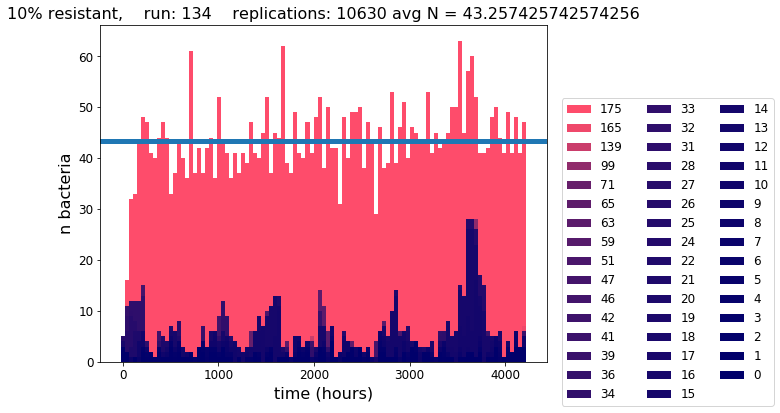

In [478]:
plotGenosInSystemOverTime(geno_dict, run_counters, runID, percent)
#plotGenosInMicroHabOverTime(geno_dict, 0, run_counters, runID, percent)

In [447]:
def printMostAndLeastReplicationsRunIDs(all_counters):
    
    replications_dict = {runID:int(all_counters[runID]['n_replications']) for runID in all_counters}
    reps_sorted = Counter(replications_dict).most_common()
    
    print("runs with the most replications")
    print(reps_sorted[:3])
    
    print("\nruns with the least replications")
    print(reps_sorted[-3:][::-1])
    
    
printMostAndLeastReplicationsRunIDs(all_counters)

runs with the most replications
[('run_ID = 134', 10630), ('run_ID = 90', 10558), ('run_ID = 4', 10473)]

runs with the least replications
[('run_ID = 118', 5625), ('run_ID = 170', 7636), ('run_ID = 85', 7672)]
